In [123]:
import random
from datetime import datetime
from tqdm.notebook import tqdm
import statistics
import matplotlib.pyplot as plt
import pandas as pd

### Generate Query Data

In [142]:
wordCount = {}
with open("train.data") as input_file:
    input_line = input_file.readline()
    while input_line:
        groupNo, wordIDx, count = map(int, input_line.split())
        if wordIDx in wordCount:
            wordCount[wordIDx] += 1
        else:
            wordCount[wordIDx] = 1
        input_line = input_file.readline()
wordCountList = []
for key, value in wordCount.items():
    wordCountList.append([key, value])
wordCountList.sort(key = lambda x: x[1], reverse = True)
print(len(wordCountList))
queryList = random.sample(wordCountList[:1000], 100)
with open("query.data", "w") as query_file:
    for a,b in queryList:
        query_file.write(str(a) + " " + str(b) + "\n")
print(queryList)

53975
[[1481, 346], [482, 1298], [8962, 221], [4367, 385], [3061, 228], [1535, 244], [764, 1175], [391, 1246], [1213, 536], [2087, 490], [1050, 446], [400, 261], [3457, 727], [2081, 1063], [3931, 247], [2924, 255], [3055, 343], [1255, 476], [31, 1598], [1557, 1336], [307, 2686], [722, 6042], [3699, 764], [301, 2308], [23, 9247], [10268, 733], [2022, 798], [2236, 454], [12, 9235], [939, 441], [763, 528], [1703, 299], [1030, 2626], [1909, 405], [1120, 570], [1065, 1205], [1028, 2911], [88, 496], [1863, 1576], [1552, 769], [2246, 308], [886, 3723], [173, 281], [1987, 305], [1416, 450], [2363, 446], [12104, 317], [67, 2522], [789, 1333], [1101, 1331], [1544, 545], [1954, 502], [4651, 312], [1413, 1571], [6429, 237], [1400, 809], [2694, 353], [5558, 295], [1130, 761], [655, 451], [308, 420], [1894, 1621], [76, 997], [72, 5061], [3363, 231], [2882, 331], [1063, 282], [1132, 405], [83, 3109], [1722, 307], [6745, 234], [3309, 237], [355, 1477], [1814, 257], [1389, 795], [132, 284], [2172, 442]

### Misra-Gries Sketch

In [102]:
class MisraGries:
    def __init__(self, k):
        self.k = k
        self.counters = {}
    def process(self, element, count):
        if element in self.counters:
            self.counters[element] += count
        elif len(self.counters) < self.k - 1:
            self.counters[element] = count
        else:
            frequencyToDecrease = count
            for key, val in self.counters.items():
                frequencyToDecrease = min(frequencyToDecrease, val)
            for key in self.counters:
                self.counters[key] -= frequencyToDecrease
            # Remove all keys whose frequency is <= 0
            self.counters = {key:val for key, val in self.counters.items() if val > 0}
            if count > frequencyToDecrease:
                self.counters[element] = count - frequencyToDecrease
            self.counters = {key:val for key, val in self.counters.items() if val > 0}
    def query(self, element):
        if element in self.counters:
            return self.counters[element]
        return 0

### Count-min Sketch

In [128]:
class CountMinSketch:
    def __init__(self, numRows, numCols):
        self.p = 104207
        self.hash_functions = []
        self.numRows, self.numCols = numRows, numCols
        for _ in range(numRows):
            random.seed(datetime.now())
            a = random.randint(1, self.p - 1)
            b = random.randint(1, self.p - 1)
            self.hash_functions.append((a,b))
        self.countArray = [[0] * numCols for i in range(numRows)]

    def hash_value(self, rowID, element):
        a, b = self.hash_functions[rowID]
        return ((a * element + b) % self.p) % self.numCols
   
    def process(self, element, count):
        for rowID in range(self.numRows):
            colID = self.hash_value(rowID, element)
            self.countArray[rowID][colID] += count
                
    def query(self, element):
        tempCountArray = []
        for rowID in range(self.numRows):
            colID = self.hash_value(rowID, element)
            tempCountArray.append(self.countArray[rowID][colID])
        return min(tempCountArray)

### count Sketch

In [136]:
class CountSketch:
    def __init__(self, numRows, numCols):
        self.p = 104207
        self.hash_functions = []
        self.sign_hash_functions = []
        self.numRows, self.numCols = numRows, numCols
        for _ in range(numRows):
            random.seed(datetime.now())
            a = random.randint(1, self.p - 1)
            b = random.randint(1, self.p - 1)
            self.hash_functions.append((a,b))
            random.seed(datetime.now())
            a = random.randint(1, self.p - 1)
            b = random.randint(1, self.p - 1)
            self.sign_hash_functions.append((a,b))
        self.countArray = [[0] * numCols for i in range(numRows)]

    def hash_value(self, rowID, element):
        a, b = self.hash_functions[rowID]
        return ((a * element + b) % self.p) % self.numCols
   
    def sign_hash_value(self, rowID, element):
        a, b = self.sign_hash_functions[rowID]
        hash_val = ((a * element + b) % self.p) % 2
        if hash_val == 0:
            return -1
        return 1
    
    def process(self, element, count):
        for rowID in range(self.numRows):
            colID = self.hash_value(rowID, element)
            sign = self.sign_hash_value(rowID, element)
            self.countArray[rowID][colID] += sign * count
                
    def query(self, element):
        tempCountArray = []
        for rowID in range(self.numRows):
            colID = self.hash_value(rowID, element)
            sign = self.sign_hash_value(rowID, element)
            tempCountArray.append(sign * self.countArray[rowID][colID])
        return int(statistics.median(tempCountArray))

### Results

In [143]:
w = 5
k_list = (100, 200, 500, 1000, 2000)
mGriesRelativeErrorList, countMinRelativeErrorList, countSketchRelativeErrorList = [], [], []
for k in tqdm(k_list, leave = False):
    d = k // w
    mGries = MisraGries(k)
    countMin = CountMinSketch(w, d)
    countSketch = CountSketch(w, d)
    with open("train.data") as input_file:
        input_line = input_file.readline()
        while input_line:
            groupNo, wordIDx, count = map(int, input_line.split())
            mGries.process(wordIDx, count)
            countMin.process(wordIDx, count)
            countSketch.process(wordIdx, count)
            input_line = input_file.readline()
    mGriesRelativeError, countMinRelativeError, countSketchRelativeError = 0, 0, 0
    with open("query.data") as query_file:
        input_line = query_file.readline()
        while input_line:
            wordIDx, actualCount = map(int, input_line.split())
            mGriesRelativeError += abs(mGries.query(wordIDx) - actualCount) / actualCount
            countMinRelativeError += abs(countMin.query(wordIDx) - actualCount) / actualCount
            countSketchRelativeError += abs(countSketch.query(wordIDx) - actualCount) / actualCount
            input_line = query_file.readline()
    mGriesRelativeError /= 100
    countMinRelativeError /= 100
    countSketchRelativeError /= 100
    mGriesRelativeErrorList.append(mGriesRelativeError)
    countMinRelativeErrorList.append(countMinRelativeError)
    countSketchRelativeErrorList.append(countSketchRelativeError)

  0%|          | 0/5 [00:00<?, ?it/s]

In [144]:
df = pd.DataFrame({'k': k_list, 
                   'misra-gries' : mGriesRelativeErrorList,
                  'count-min' : countMinRelativeErrorList,
                  'count sketch' : countSketchRelativeErrorList})
df = df.set_index('k')
display(df)
# print(mGriesRelativeErrorList)
# print(countMinRelativeErrorList)
# print(countSketchRelativeErrorList)

,misra-gries,count-min,count sketch
k,,,
100,1.037450,212.027074,1.0
200,1.055882,97.079551,1.0
500,1.043038,32.329254,1.0
1000,1.023132,14.817722,1.0
2000,0.851478,6.404792,1.0


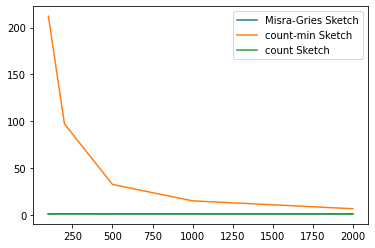

In [145]:
plt.plot(k_list, mGriesRelativeErrorList, label = "Misra-Gries Sketch")
plt.plot(k_list, countMinRelativeErrorList, label = "count-min Sketch")
plt.plot(k_list, countSketchRelativeErrorList, label = "count Sketch")
plt.legend()
plt.show()